In [1]:
import os
import cv2
import math
import time
import pickle
import numpy as np
from random import randint
from skimage.feature import hog
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.svm import LinearSVC, SVC
from sklearn import preprocessing
from sklearn.externals import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

In [2]:
Veh_Imgs_Path = "./../udacity_dataset/vehicles/vehicles/"
NonVeh_Imgs_Path = "./../udacity_dataset/non_vehicles/non_vehicles/"

Veh_Imgs = os.listdir(Veh_Imgs_Path)
NonVeh_Imgs = os.listdir(NonVeh_Imgs_Path)

In [3]:
def CollectImages(folderpath, ImagePaths, isLabeled = True):
    images = []
    for ImagePath in ImagePaths:
        if (len(ImagePath.split('.')) == 2):
            im = cv2.imread(folderpath + ImagePath)
            im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
            #print('Image ' , ImagePath , ' is: ', type(im), ' with dimensions: ', im.shape)
            if isLabeled == True:
                images.append((im, ImagePath.split('.')[0]))
            else:
                images.append(im)
        else:
            print('Image', ImagePath, 'is correupted --> Discarded.')

    return images

In [4]:
CarImageSet = []
NonCarImageSet = []

for folder in Veh_Imgs:
    folderpath = Veh_Imgs_Path + folder
    Carsimagespath = os.listdir(folderpath)
    CarImageSet.append(CollectImages(folderpath + '/', Carsimagespath, True))

for folder in NonVeh_Imgs:
    folderpath = NonVeh_Imgs_Path + folder
    NonCarsimagespath = os.listdir(folderpath)
    NonCarImageSet.append(CollectImages(folderpath + '/', NonCarsimagespath, True))

CarImageSet = np.concatenate(CarImageSet)
NonCarImageSet = np.concatenate(NonCarImageSet)

print('Car Image Set has ', str(len(CarImageSet)))
print('Non Car Image Set has ', str(len(NonCarImageSet)))

Car Image Set has  8792
Non Car Image Set has  8968


In [5]:
Inpath  = "./test_images"
TestimagesPaths = os.listdir(Inpath)

TestImages = CollectImages(Inpath + '/', TestimagesPaths, isLabeled = False)

In [6]:
imgPxlVal = 0
img_Label = 1

In [7]:
def pltImages(images, labels, nrows = 1, ncols = 2, fig_w = 20, fig_h = 10, isgray = False):
    #below code is inspired from https://stackoverflow.com/questions/17111525/how-to-show-multiple-images-in-one-figure
    assert len(images) <= (nrows * ncols)
    if labels != "":
        assert len(images) == len(labels)
    
    fig = plt.figure(figsize=(fig_w, fig_h))
    
    for index in range(len(images)):
        plot = fig.add_subplot(nrows,ncols,index+1)
        if labels != "":
            plot.set_title(labels[index])
        if(isgray == False):
            plt.imshow(images[index].squeeze())
        else:
            plt.imshow(images[index].squeeze(), cmap='gray')
    
    plt.tight_layout()
    plt.show()

In [8]:
#Code obtained from lessons
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  block_norm= 'L2',
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       block_norm= 'L2',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [9]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, debug=False):
    
    draw_img = np.copy(img)
    #img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1 or debug == True:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img

In [10]:
def TrainLinearSVCModel(feat, label):
    svc = LinearSVC()
    svc.fit(feat, label)

    return svc

#below code is obtained from http://scikit-learn.org/stable/modules/model_persistence.html and twicked to dumb dictionary data
def SaveClassifier(clf, Scaler, CHist_EN, SB_EN, HOG_EN, Nrmlz,
                   histSize, Hist_colorspace, CS_Ch_Idx, size, 
                   SB_colorspace, HOG_colorspace, orient, pix_per_cell,
                   cells_per_block, blk_Norm, TransformSqrt, 
                   HOG_Ch_Idx, Name='TrainedClassifier.pkl'):
    
    Class_dict = { 'clf': clf, 'Scaler': Scaler, 'CHist_EN' : CHist_EN, 'SB_EN' : SB_EN, 'HOG_EN' : HOG_EN,
                   'Nrmlz' : Nrmlz, 'histSize' : histSize, 'Hist_colorspace' : Hist_colorspace,
                   'CS_Ch_Idx' : CS_Ch_Idx, 'size' : size, 'SB_colorspace' : SB_colorspace,
                   'HOG_colorspace' : HOG_colorspace, 'orient' : orient, 'pix_per_cell' : pix_per_cell,
                   'cells_per_block' : cells_per_block, 'blk_Norm' : blk_Norm, 'TransformSqrt' : TransformSqrt,
                   'HOG_Ch_Idx' : HOG_Ch_Idx}
    
    output = open(Name, 'wb')
    pickle.dump(Class_dict, output)
    output.close()

def LoadClassifier(Name='TrainedClassifier.pkl'):
    classifier = pickle.load( open(Name, "rb" ) )
    return pickle.load( open(Name, "rb" ) )

In [11]:
classifier = LoadClassifier("TrainedClassifier0.pkl")
clf       = classifier['clf']
Feature_scaler = classifier['Scaler']
CHist_EN  = classifier['CHist_EN']
SB_EN     = classifier['SB_EN']
HOG_EN    = classifier['HOG_EN']
Nrmlz     = classifier['Nrmlz']
histSize  = classifier['histSize']
Hist_colorspace = classifier['Hist_colorspace']
CS_Ch_Idx = classifier['CS_Ch_Idx']
size      = classifier['size']
SB_colorspace   = classifier['SB_colorspace']
HOG_colorspace  = classifier['HOG_colorspace']
orient    = classifier['orient']
pix_per_cell    = classifier['pix_per_cell']
cells_per_block = classifier['cells_per_block']
blk_Norm  = classifier['blk_Norm']
TransformSqrt   = classifier['TransformSqrt']
HOG_Ch_Idx= classifier['HOG_Ch_Idx']

print(clf)
print(Feature_scaler)
print(CHist_EN)
print(SB_EN)
print(HOG_EN)
print(Nrmlz)
print(histSize)
print(Hist_colorspace)
print(CS_Ch_Idx)
print(size)
print(SB_colorspace)
print(HOG_colorspace)
print(orient)
print(pix_per_cell)
print(cells_per_block)
print(blk_Norm)
print(TransformSqrt)
print(HOG_Ch_Idx)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
StandardScaler(copy=True, with_mean=True, with_std=True)
True
True
True
True
[64]
LUV
All
(16, 16)
LUV
LUV
8
16
2
L2
True
All


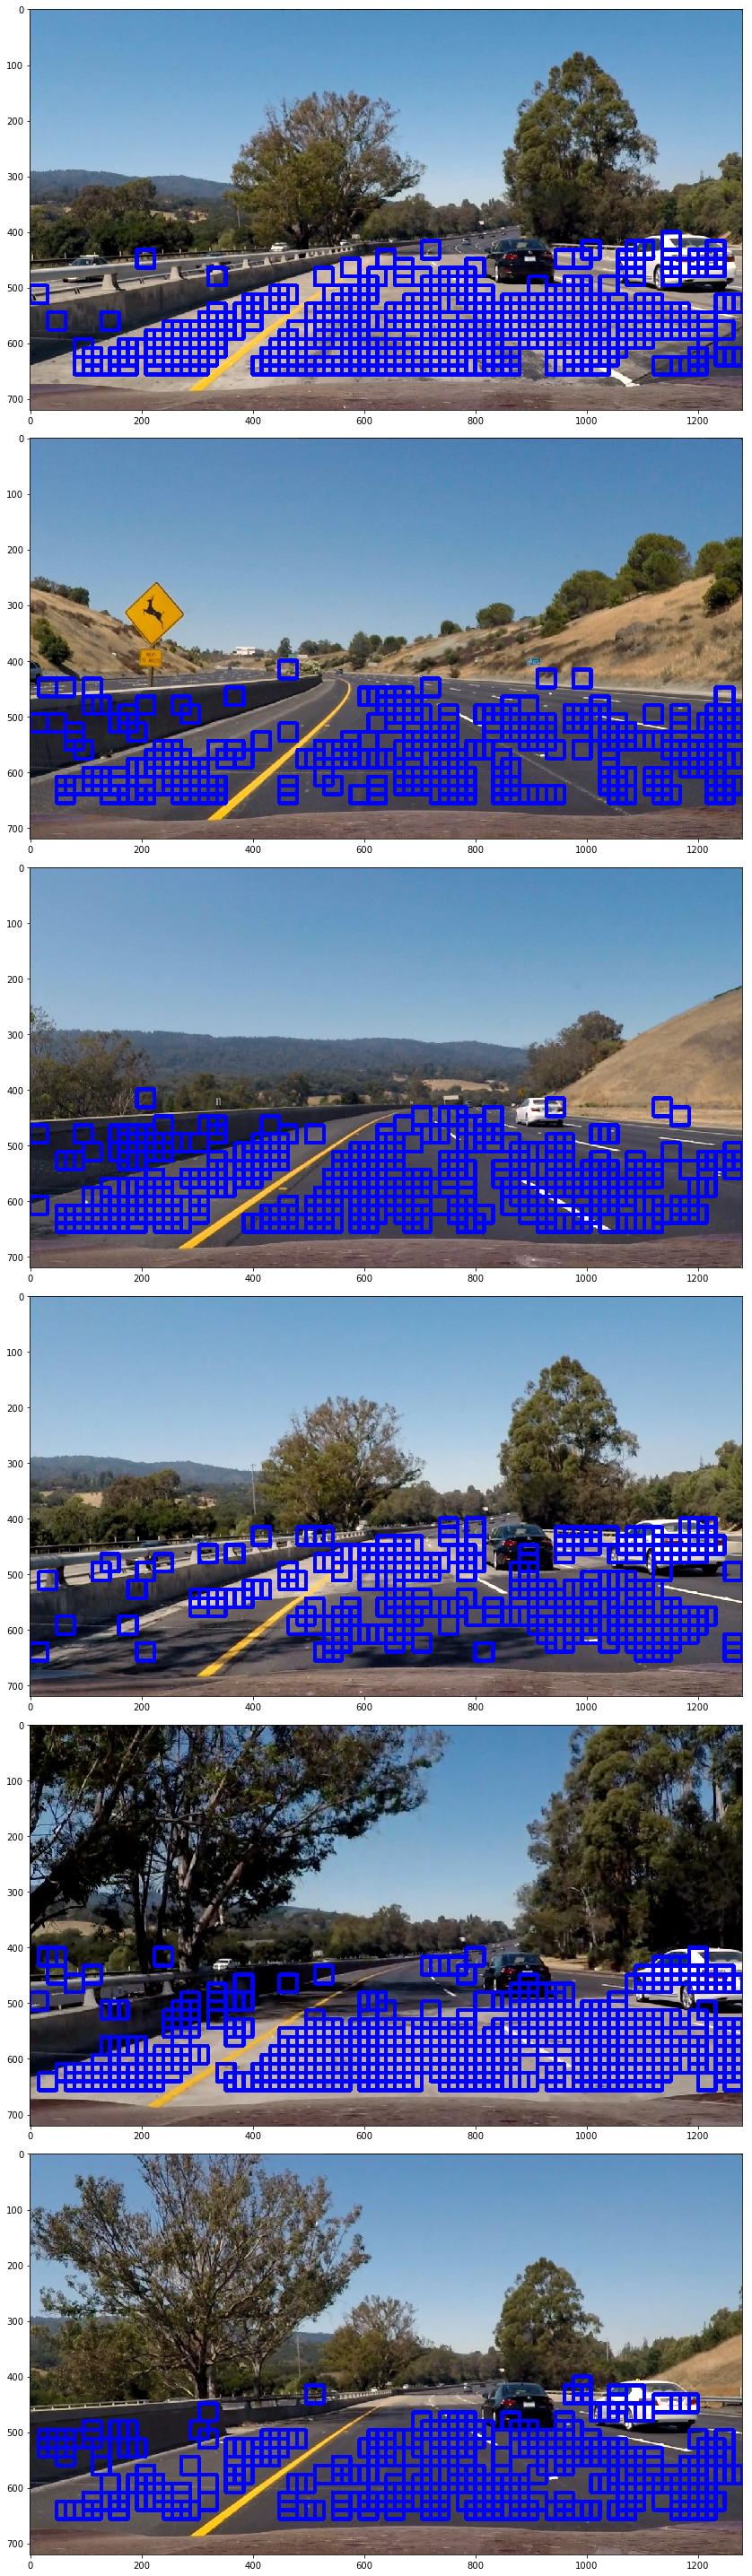

In [12]:
OutputImage = []
ystart = 400
ystop = 656
scale = 0.5

orient = 8
pix_per_cell = 16
cells_per_block = 2

debug = False

for image in TestImages:
    OutputImage.append(find_cars(image,ystart,ystop,scale,clf,Feature_scaler,orient,pix_per_cell,cells_per_block,(16,16),64,debug))

pltImages(OutputImage, "", 6, 1, 20, 40)

Classifier seems to behave wrong, retrain to test with lesson function

In [41]:
def Lessons_ExtractFeature(img):
    #Since All Feature Space are in LUV so switch to it one time
    ctrans_tosearch = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cells_per_block, feature_vec=True)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cells_per_block, feature_vec=True)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cells_per_block, feature_vec=True)
    hog_features = np.hstack((hog1, hog2, hog3))
    
    spatial_features = bin_spatial(img, size=size)
    hist_features = color_hist(img, nbins=histSize[0])
    
    return np.hstack((spatial_features, hist_features, hog_features))

In [43]:
lessonsCar_features = []
lessonNonCar_features = []

for image in CarImageSet:
    lessonsCar_features.append(Lessons_ExtractFeature(image[imgPxlVal]))
for image in NonCarImageSet:
    lessonNonCar_features.append(Lessons_ExtractFeature(image[imgPxlVal]))

In [46]:
lesson_FeatureSet = np.vstack((lessonsCar_features, lessonNonCar_features)).astype(np.float64)
lesson_LbaelSet = np.hstack((np.ones(len(lessonsCar_features)), np.zeros(len(lessonNonCar_features))))

lessonrand_state = 20
#lrand_state = np.random.randint(0, 100)
lessonFeature_train, lessonFeature_test, lessonLabel_train, lessonLabel_test = train_test_split(
    lesson_FeatureSet, lesson_LbaelSet, test_size=0.2, random_state=lessonrand_state)
    
lessonFeature_scaler = StandardScaler().fit(lessonFeature_train)
leesonScaled_FeatureTrainSet = lessonFeature_scaler.transform(lessonFeature_train)
lessonScaled_FeatureTestSet = lessonFeature_scaler.transform(lessonFeature_test)

lessonclf = TrainLinearSVCModel(leesonScaled_FeatureTrainSet, lessonLabel_train)

Name = "LessonTrainedClassifier.pkl"
SaveClassifier(lessonclf, lessonFeature_scaler, CHist_EN, SB_EN, HOG_EN, Nrmlz, 
               histSize, Hist_colorspace, CS_Ch_Idx, size, SB_colorspace, 
               HOG_colorspace, orient, pix_per_cell, cells_per_block, blk_Norm, TransformSqrt,
               HOG_Ch_Idx, Name)

In [47]:
print(lessonclf.score(lessonScaled_FeatureTestSet, lessonLabel_test))

0.994369369369


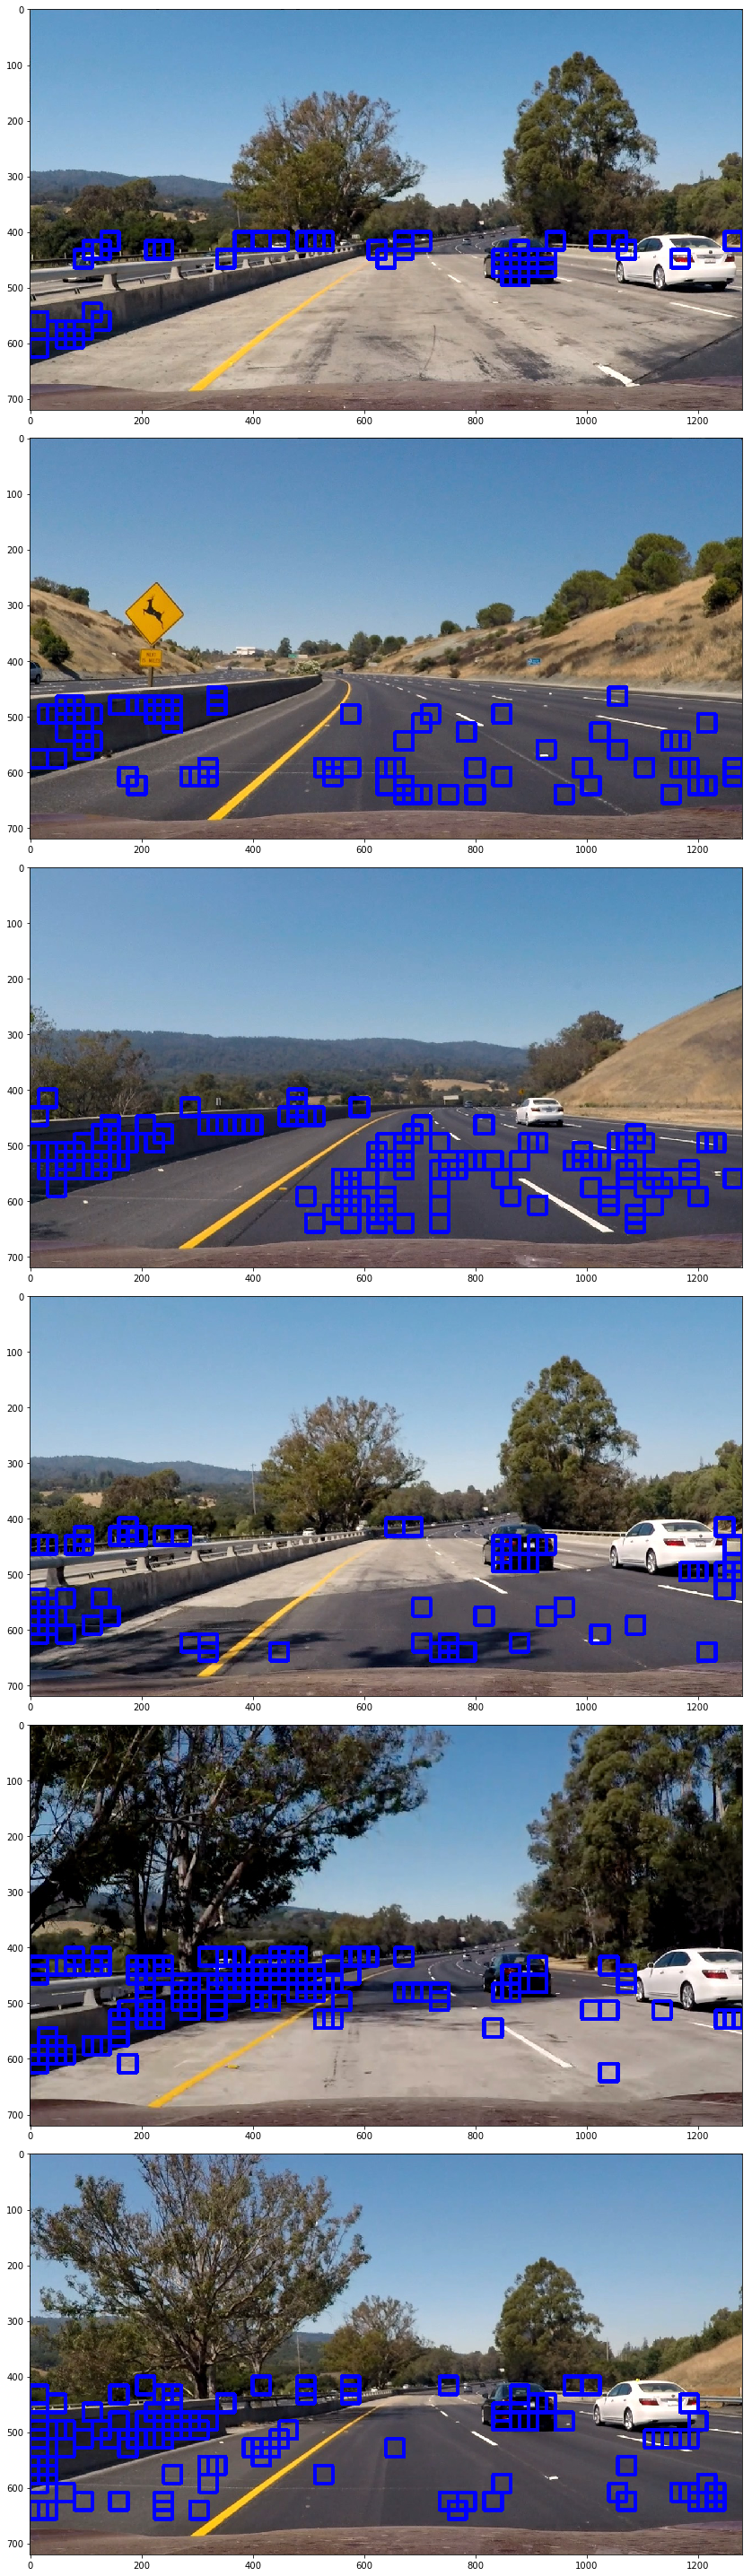

In [48]:
OutputImage = []
ystart = 400
ystop = 656
scale = 0.5

orient = 8
pix_per_cell = 16
cells_per_block = 2

debug = False

for image in TestImages:
    OutputImage.append(find_cars(image,ystart,ystop,scale,lessonclf,lessonFeature_scaler,orient,pix_per_cell,cells_per_block,(16,16),64,debug))

pltImages(OutputImage, "", 6, 1, 20, 40)